In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as c
from scipy.interpolate import interp1d
import numpy as np
%matplotlib notebook

# ENPH453 Session 3: March 5, 2019
### Alex White, Curtis Shewchuk, Viraj Bangari

## Electron Spin Resonance

#### Apparatus
We set up our apparatus like this block diagram:

![](./data/apparatus.png)


Lock in amplifier model: SR830 DSP

Audio amplifier: BOGEN C20C

Function Generator: Wavetek Model 19

Oscilliscope: Tektronix TD3012B

Helmholtz Coil: Custom built

Wavemeter: FXR Inc Type X410A

Preamp: Ithaco Model 565

Biopolar Power Supply: Kepco


##### Calibration Steps
To calibrate the Klysotron, we set the modulating function to be a square wave. We connected the output of the EM-detector to an oscilliscope while bypassing the amplifier. We adjusted the reflector settting on the scope such that the top of the wave had no pitch. Our reflector dial setting was 5,29 and the beam is at 325 settings. An example of this present in the photograph below:

<img src="./data/klystron_calibration.jpg" width="400">

Then we connected output of the wavemeter into while bypassing the preamp. We observed a DC signal which is proportional to the power of the microwave radiation. We then tunes the the cavity resonator until a minimum signal was observed. This happened at a setting of: $9.945 \pm 4 GHz$. The current control settings were at 2A. The function generator usd a frequnec of 200 Hz.

There is a known peak at $13 \mu A$ on the B-Field controller $(3.15-3.16 kG)$ 

which is at 
$(9,20)$ on the current control dial (Kepco power supply)


##### Observation of Lissajous
We put the scope in XY mode and observed a Lissajous corresponding to the spectra 

<img src="./data/nice_lissajous.jpg" width="400">
<img src="./data/nice_lissajous2.jpg" width="400">

#### LabVIEW Measurments of Crystal : Initial
lock-in Time constant = $ 300 ms $
lock-in Gain = $ 200 mV $
`phase` = -30.28
#### Measurement of DPPH
We placed the DPPH sample inside the apparatus. We looked for the resonance peak.

$$B = 3.54 kG$$ @ resonant frequency of $$9.945 GHz$$


#### Measurement of Manganese

In [79]:
c.h
c.mu_0
c.alpha
f = 9.945e9
# From "Paramagnetic Resonance and Optical Absorption Spectra of Cr'+ in MgOt"
# http://digitool.library.mcgill.ca/webclient/StreamGate?folder_id=0&dvs=1554233848316~919
mu_b = 9.275e-24

A_cr_f = 49.33e6
g_cr = 1.98
A_cr = (c.h * A_cr_f) / (g_cr * mu_b) * 10e3
print("A_cr", A_cr)

ml_cr = np.array([-2, -1, 1, 2])
B_cr = (c.h * f - A_cr * ml_cr)/(g_cr * mu_b) * 10e3
B_dpph = c.h * f/(2.0036 * mu_b) * 10e3
print("B dpph", B_dpph)

A_cr 17.798689595317054
B dpph 3545.9766247062566


In [80]:
A_mg_f = 244.5e6
g_mg = 2

A_mg = (c.h * A_mg_f) / (g_mg * mu_b) * 10e3
print("A_mg", A_mg)

A_mg 87.33553233315364


### Data Collection Process

Finding the peak of DPPH. We wrote a script that finds the point that cross the x-axis to determine the peak value. The results are presented below

In [65]:
from scipy import stats

def get_B_fit(B, t, midpointsToFind=2000):
    start = 0
    B_new = []
    t_new = []
    
    found = 0
    for end in range(1, len(B)):
        if B[start] != B[end]:
            mid = (start + end)//2
            B_new.append(B[mid])
            t_new.append(t[mid])
            start = end
            found += 1
            if found >= midpointsToFind:
                break
    m, b, _, _, _ = stats.linregress(t_new, B_new)
    
    def B_fit(t):
        return m * t + b
    
    return B_fit

def plot_data(df, reverse=False):
    accessor = 1
    if reverse:
        accessor = -1

    time_no_dpph = np.array(df[" time [ms]"])[::accessor]
    b_no_dpph = np.array(df["B [Gauss]"])[::accessor]
    I = np.array(df["X  [Volt]"])[::accessor]
    B_fit = get_B_fit(b_no_dpph, time_no_dpph)
    b = B_fit(time_no_dpph)
    plt.figure()
    plt.subplot(311)
    plt.plot(time_no_dpph, b_no_dpph)
    plt.plot(time_no_dpph, b)
    plt.plot()
    
    plt.subplot(312)
    plt.xlabel("Magnetic Field [G]")
    plt.ylabel("Intensity [V]")
    plt.plot(I)
    
    plt.subplot(313)
    plt.xlabel("Magnetic Field [G]")
    plt.ylabel("Intensity [V]")
    plt.plot(b, I, 'o', markersize=1)
    
    return b, I


def guessPeaks(I, threshold):
    guesses = []
    downI = 0
    foundDown = False
    foundUp = False
    for i in range(len(I)):
        if not foundDown and I[i] < -threshold:
            downI = i
            foundDown = True
        elif foundDown and not foundUp and I[i] > threshold:
            foundUp = True
        elif foundUp and I[i] < threshold:
            guesses.append((downI, i))
            foundUp = False
            foundDown = False
    
    return guesses
        
def getPeaks(B, I, guessLocations):
    peaks = []
    for location in guessLocations:
        low, hi = location
        I_interp = interp1d(B[low:hi], I[low:hi]) 
        B_sim = np.linspace(B[low], B[hi - 1], 20)
        plt.plot(B_sim, I_interp(B_sim))
        peaks.append(B_sim[np.argmin(np.abs(I_interp(B_sim)))])
    
    print("Peaks found:", len(peaks))
    return peaks

<IPython.core.display.Javascript object>


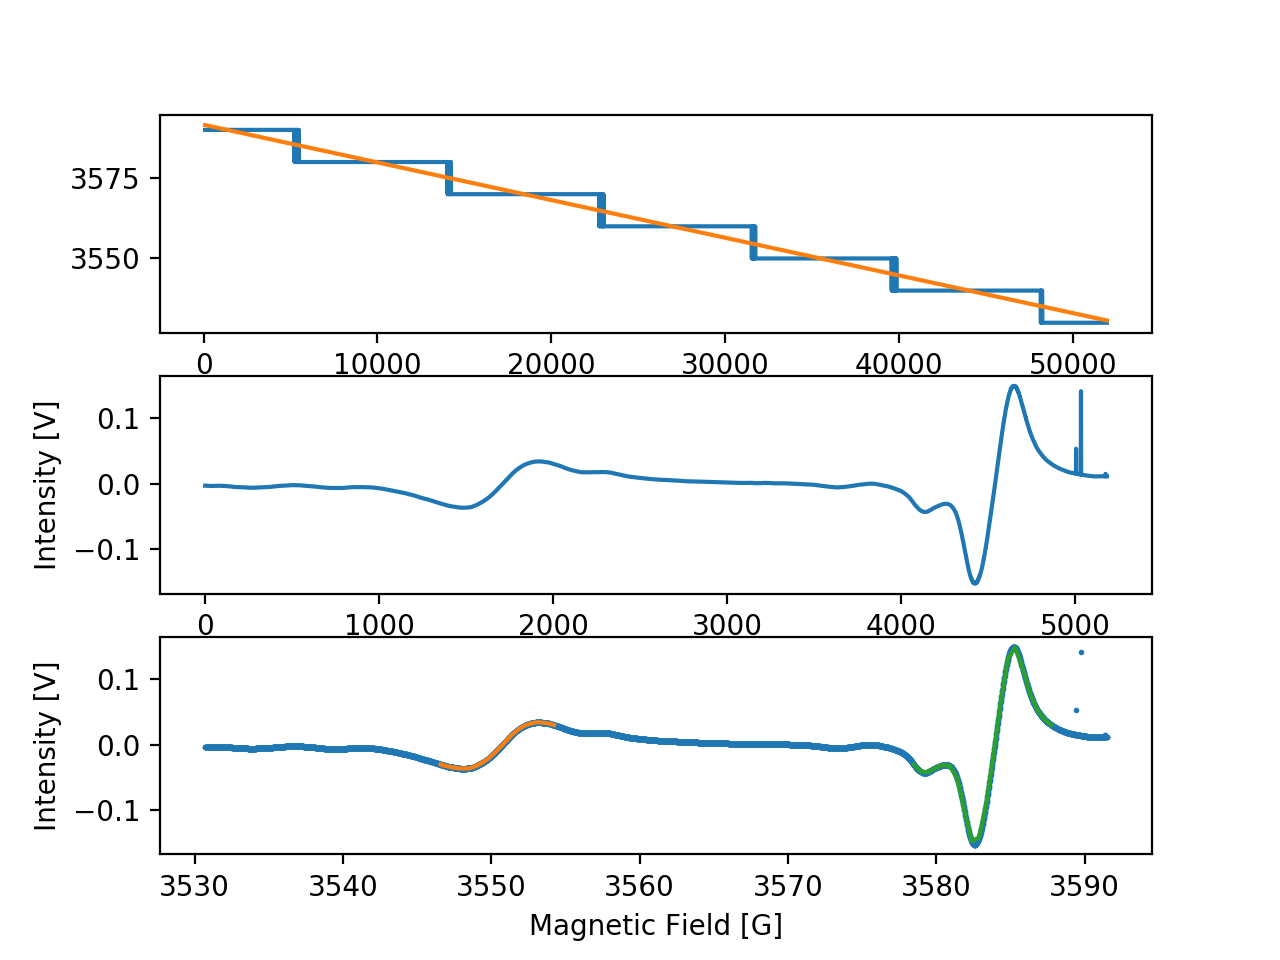

Peaks found: 2


<IPython.core.display.Javascript object>


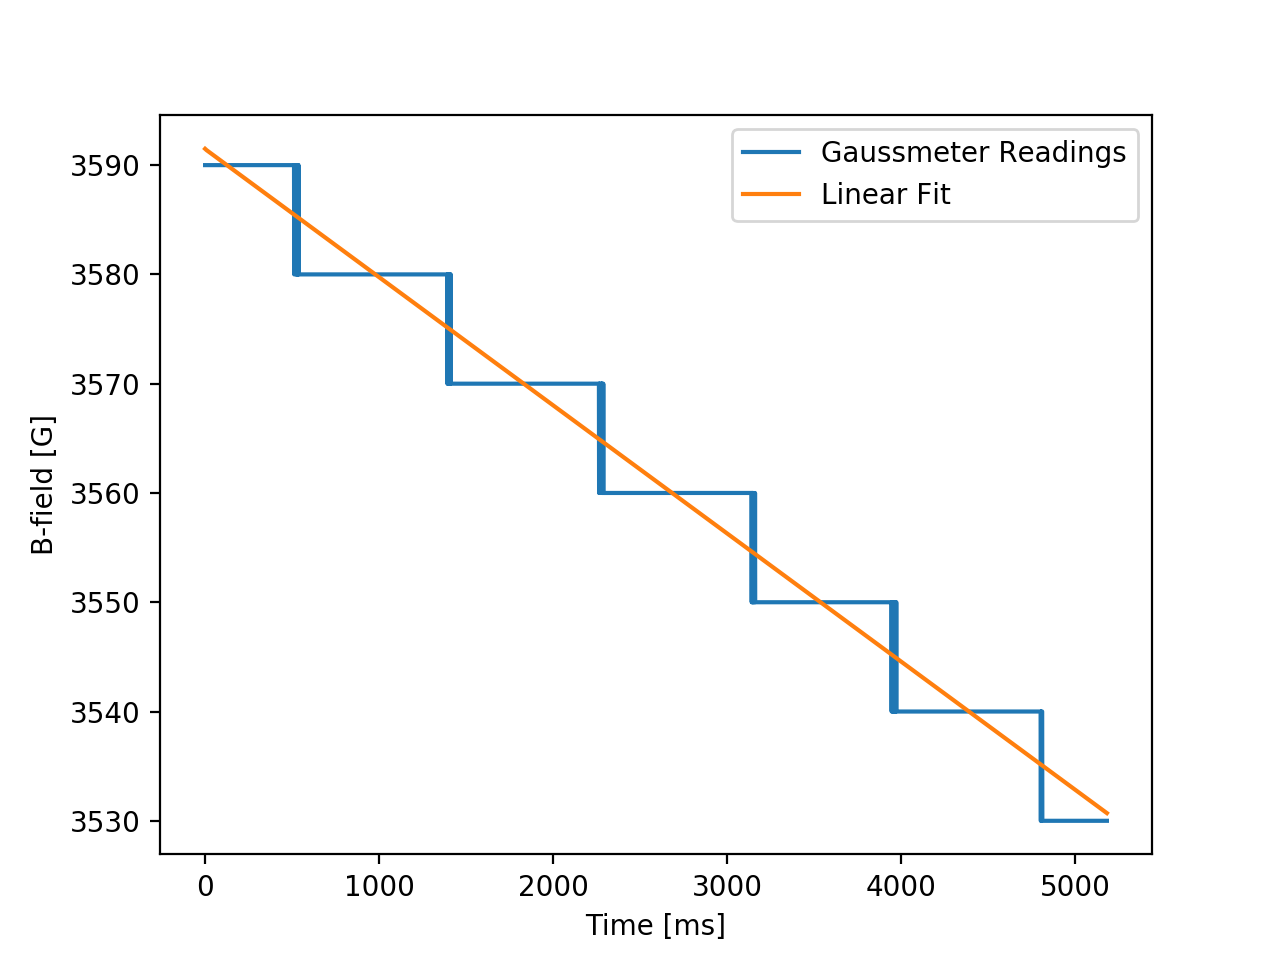

In [66]:
df = pd.read_csv("./data/sweep_no_dpph.csv")
B_none, I_none = plot_data(df, reverse=True)
_ = getPeaks(B_none, I_none, guessPeaks(I_none, 0.03))


plt.figure()
plt.plot(df["B [Gauss]"], label="Gaussmeter Readings")
plt.plot(B_none[::-1], label="Linear Fit")
plt.xlabel("Time [ms]")
plt.ylabel("B-field [G]")
plt.legend()

<IPython.core.display.Javascript object>


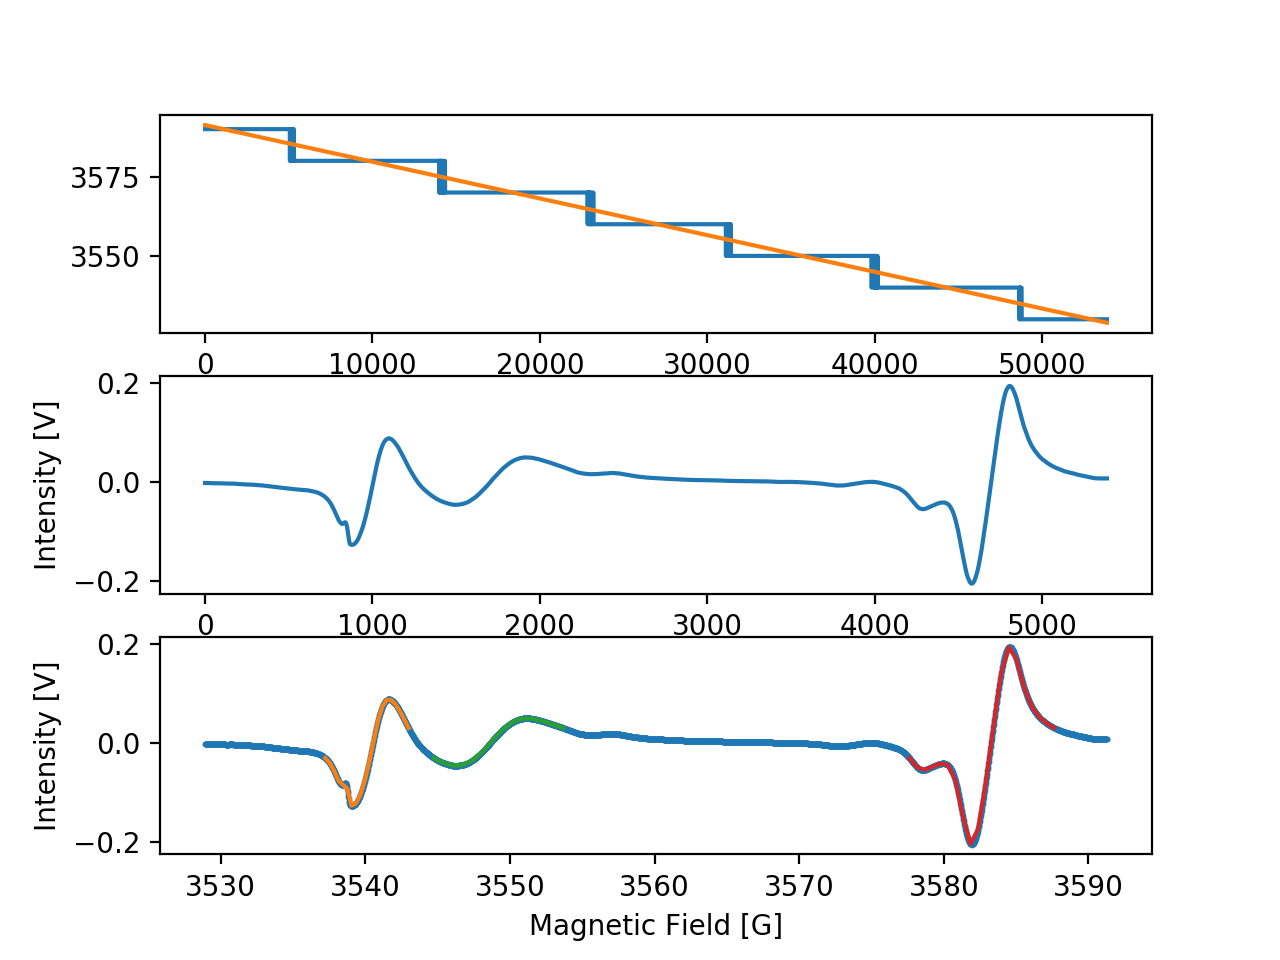

Peaks found: 3


In [67]:
df = pd.read_csv("./data/sweep_dpph.csv")
B, I = plot_data(df, reverse=True)
_ = getPeaks(B, I, guessPeaks(I, 0.03))

<IPython.core.display.Javascript object>


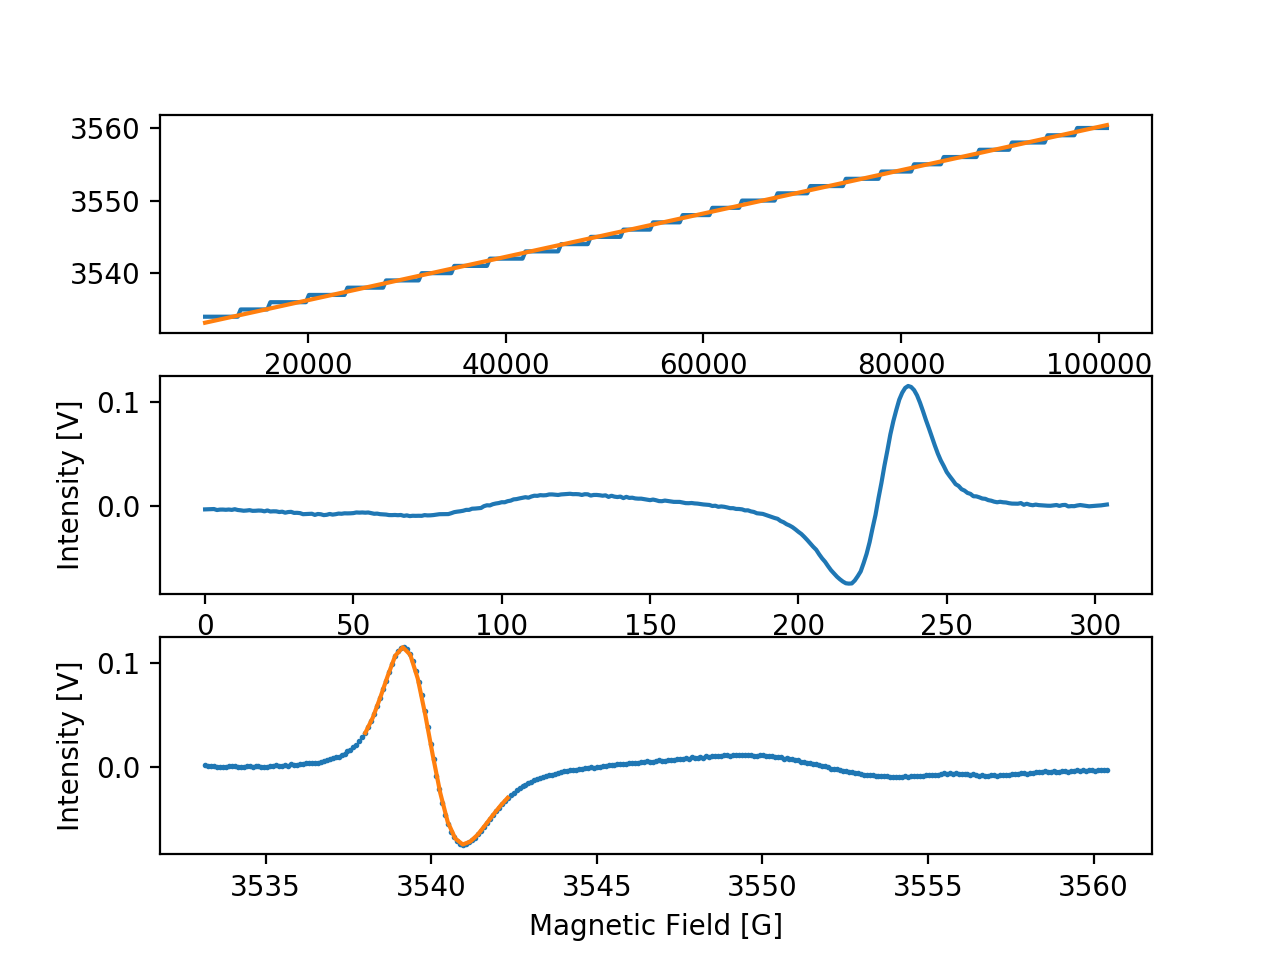

Peaks found: 1


In [68]:
df = pd.read_csv("./data/sweep_dpph_gauss.csv")
B_dpph, I_dpph = plot_data(df, reverse=True)
_ = getPeaks(B_dpph, I_dpph, guessPeaks(I_dpph, 0.03))

### Full spectra data

This was taken at zero degrees:

<IPython.core.display.Javascript object>


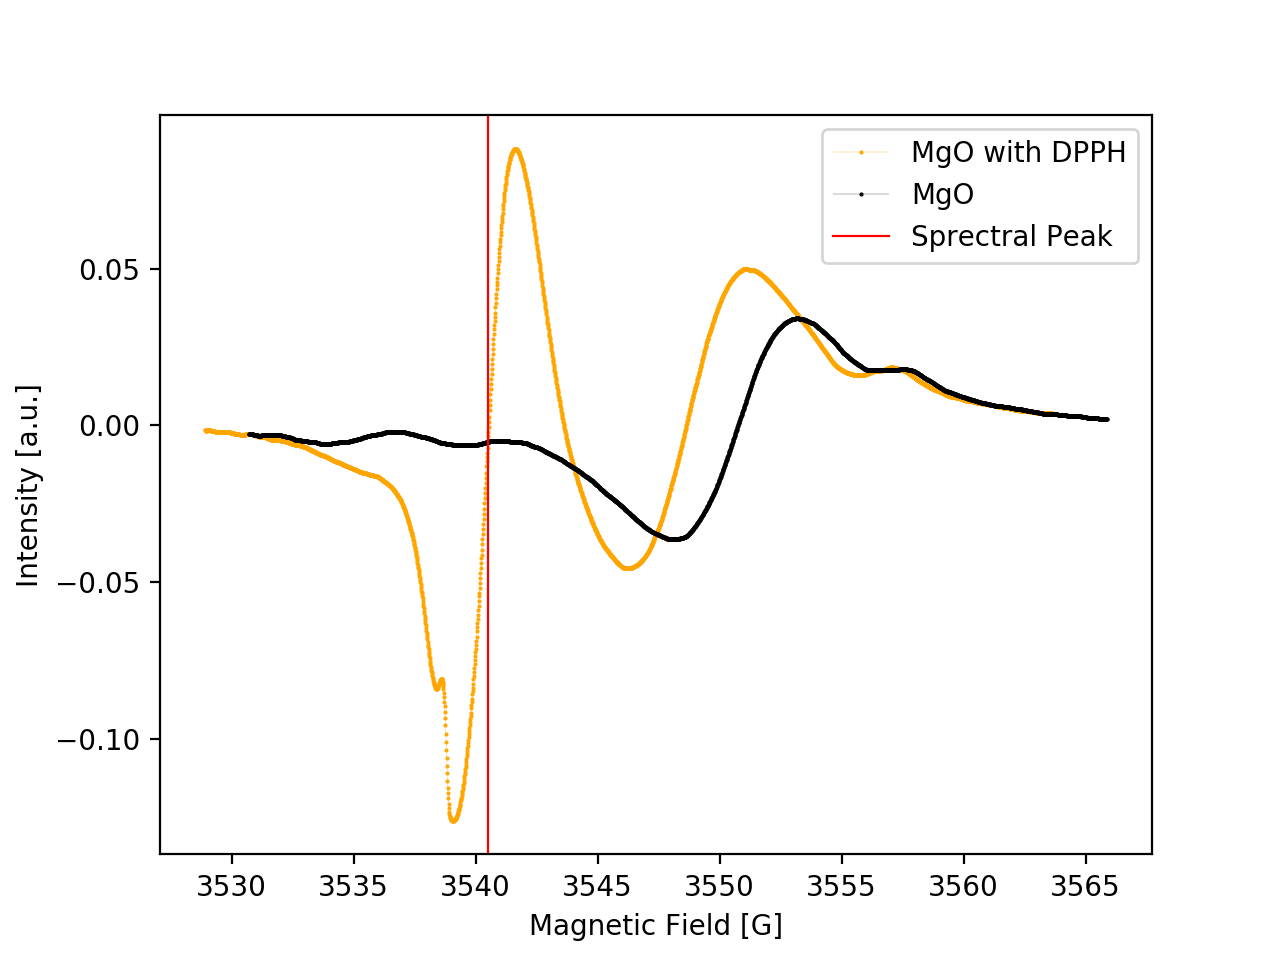

In [69]:
plt.figure()
plt.plot(B[:3000], I[:3000], '.-', label="MgO with DPPH", color='orange', markersize=1, linewidth=0.1)
plt.plot(B_none[:3000], I_none[:3000], '.-', label="MgO", color='black', markersize=1, linewidth=0.1)
plt.axvline(3540.5, color='red', label="Sprectral Peak", linewidth=0.8)
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()

<IPython.core.display.Javascript object>


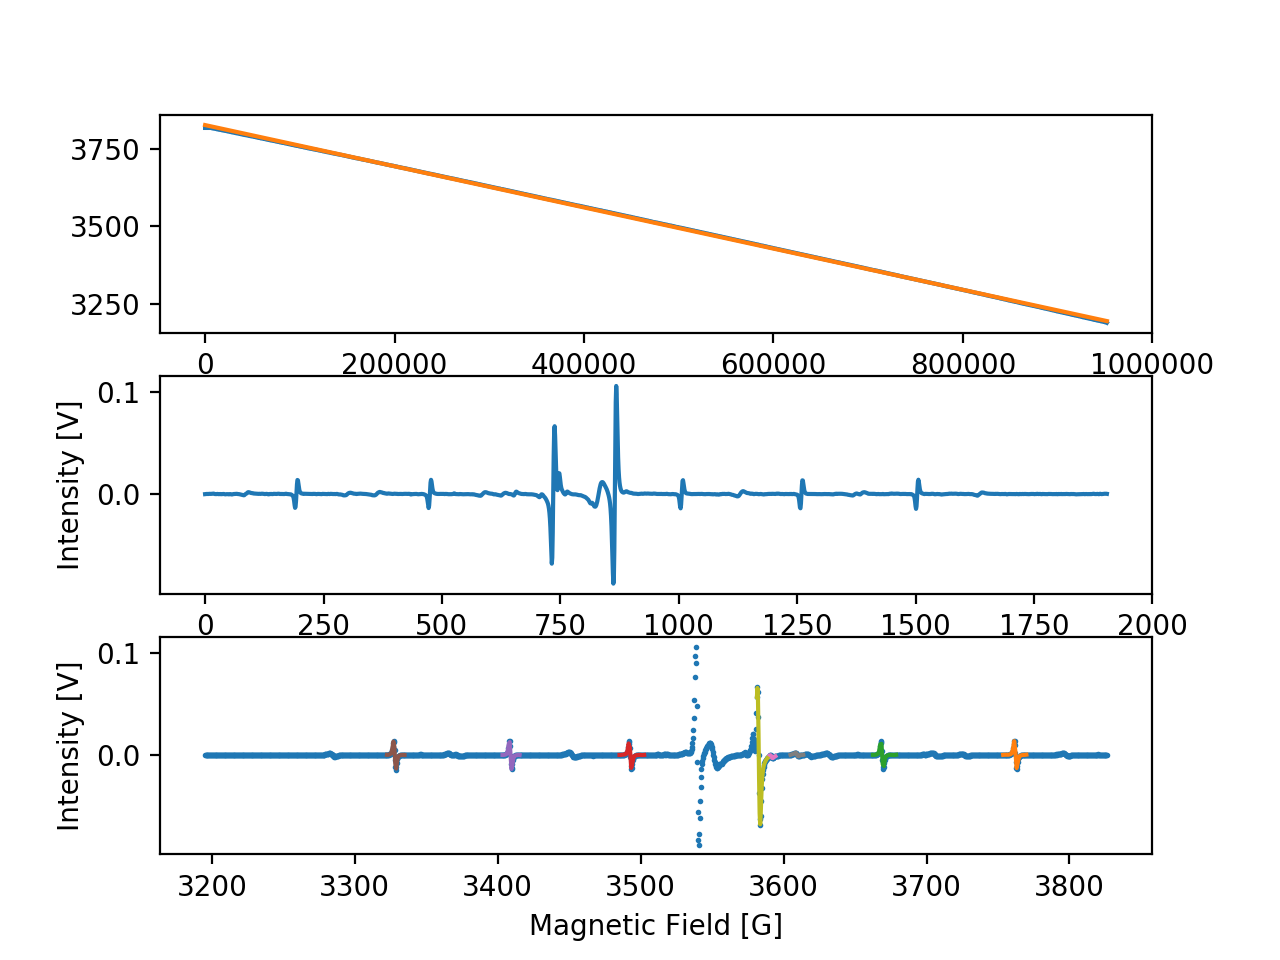

Peaks found: 5
-82.23473504213523 +/- 5, Actual 87.33553233315364
Peaks found: 3
-20.36281044079078 +/- 5, Actual 17.798689595317054


In [95]:
df = pd.read_csv("./data/Zero Degree.csv")
B_0, I_0 = plot_data(df)
Mg_peaks = getPeaks(B_0, I_0, [(170, 220), (445, 495), (977, 1030), (1240, 1277), (1483, 1521)])

Mg_A_guesses = np.array([Mg_peaks[1] - Mg_peaks[0],
          Mg_peaks[3] - Mg_peaks[2],
          Mg_peaks[4] - Mg_peaks[3]])

Mg_A_guess = np.mean(-Mg_A_guess)
print(Mg_A_guess, "+/- 5, Actual", A_mg)

Cr_peaks = getPeaks(B_0, I_0, [(700, 715), (641, 669), (717, 740)])
Cr_A_guesses = np.array([Cr_peaks[1] - Cr_peaks[0],
                         Cr_peaks[2] - Cr_peaks[0]])
print(3592 - Cr_peaks[1], "+/- 5, Actual", A_cr)

## df = pd.read_csv("./data/45 Degree.csv")
B_45, I_45 = plot_data(df)

<IPython.core.display.Javascript object>


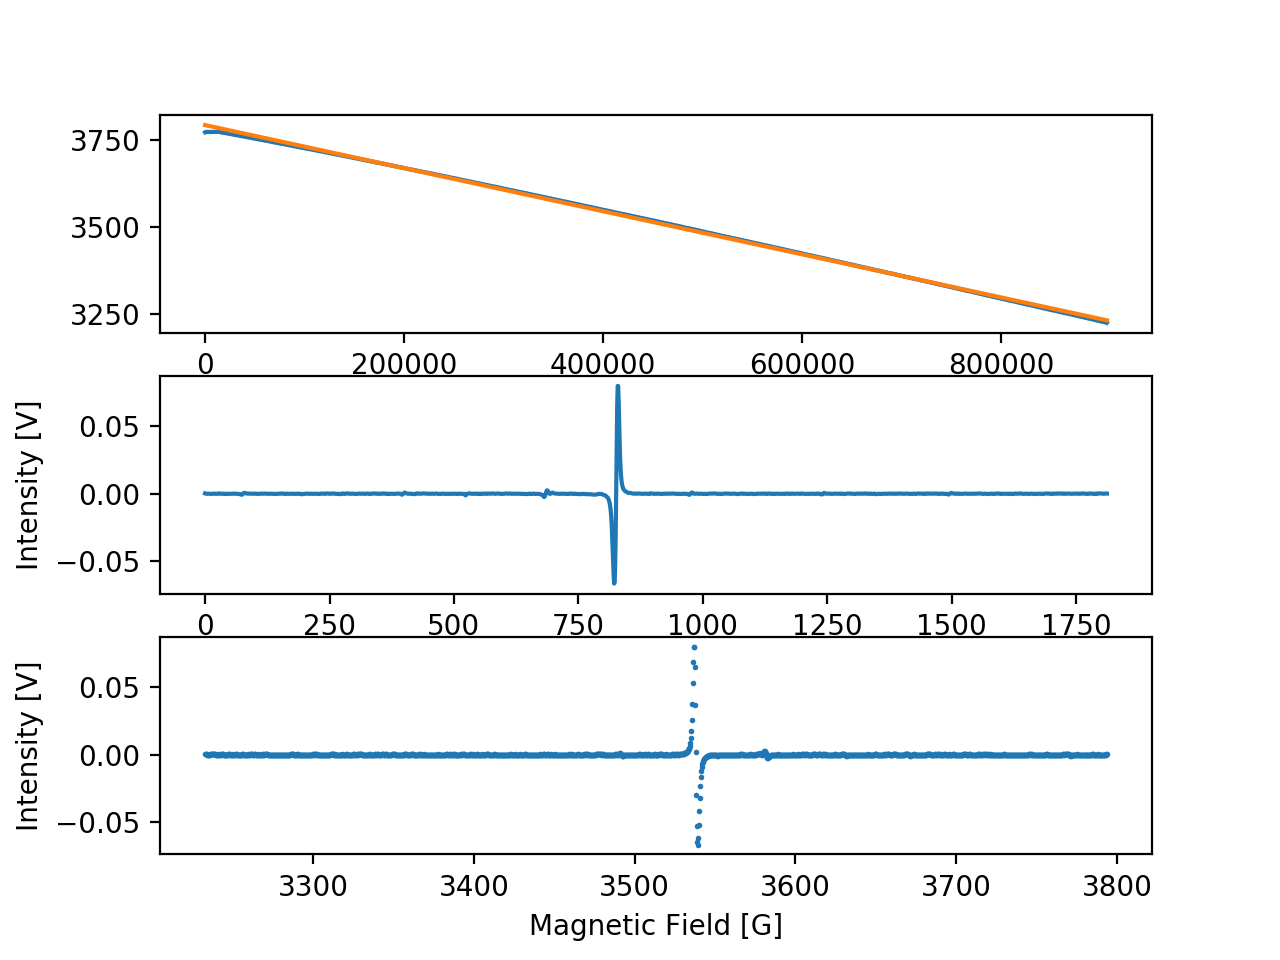

In [40]:
df = pd.read_csv("./data/90 Degree.csv")
B_90, I_90 = plot_data(df)

<IPython.core.display.Javascript object>


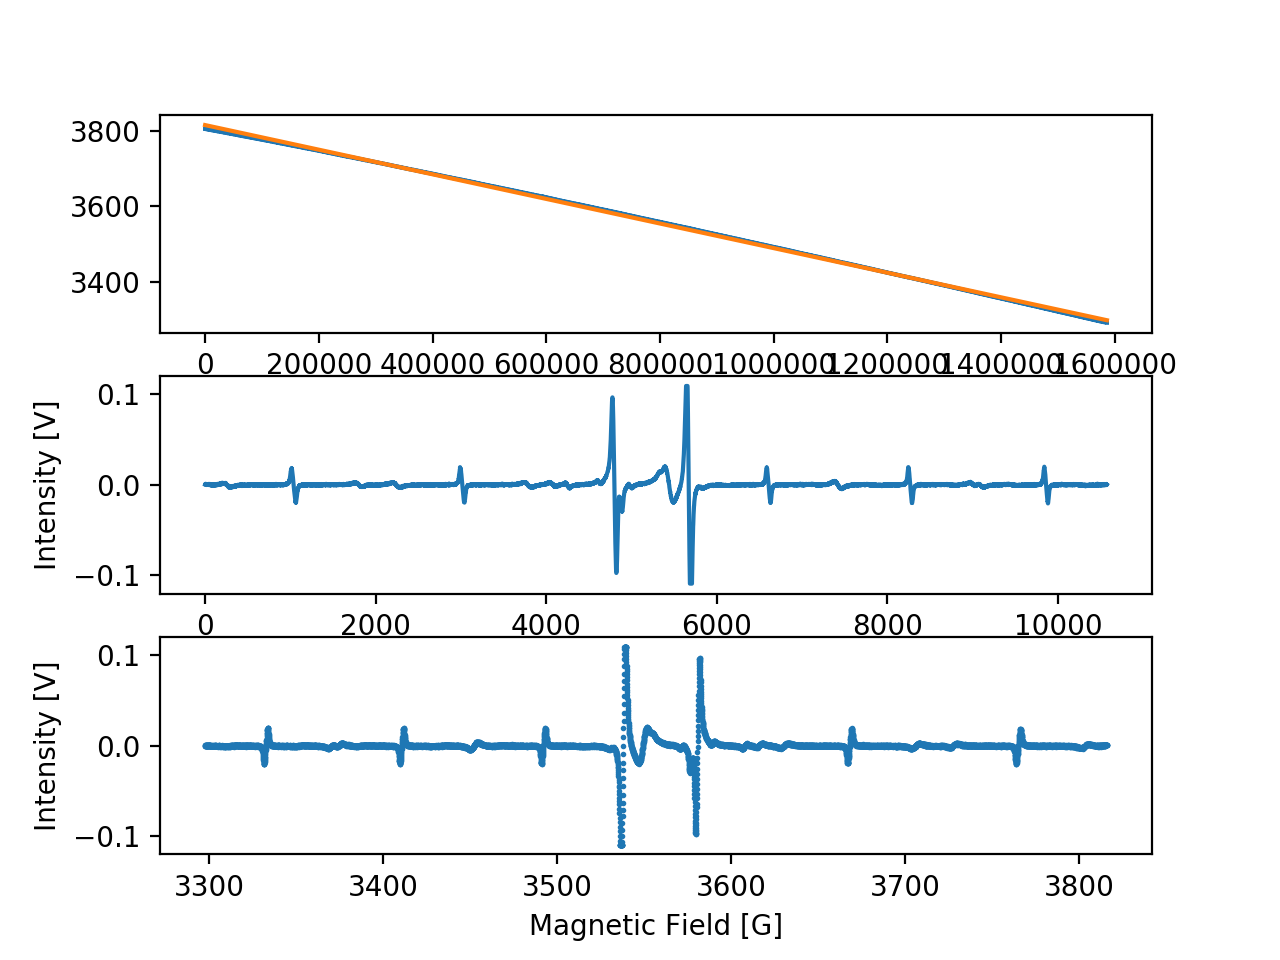

In [41]:
df = pd.read_csv("./data/finalDay_zeroDegree_slow.csv")
B_0_2, I_0_2 = plot_data(df)

<IPython.core.display.Javascript object>


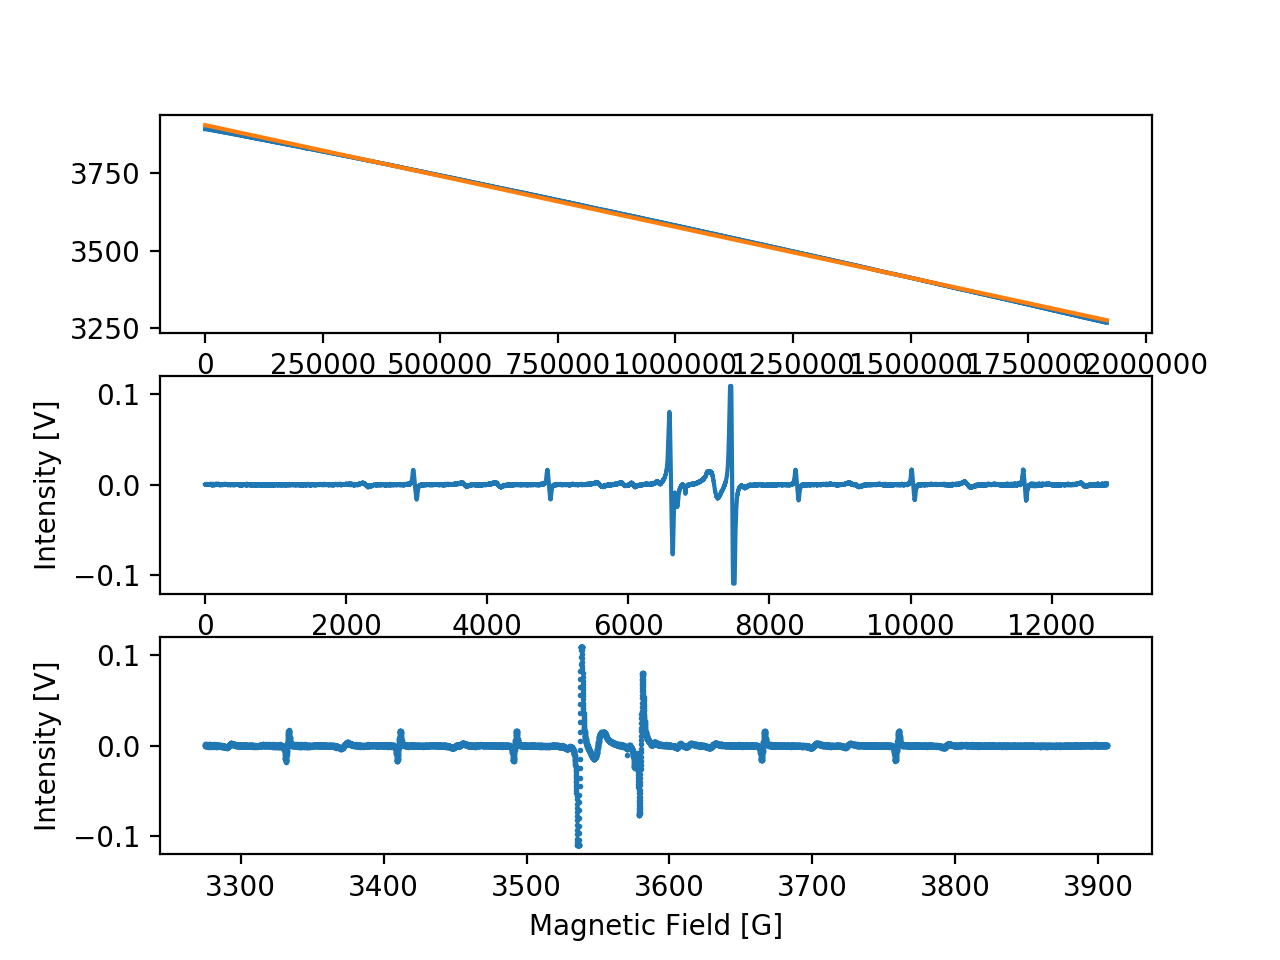

In [42]:
df = pd.read_csv("./data/finalDay_angleSweep_25.csv")
B_25, I_25 = plot_data(df)

<IPython.core.display.Javascript object>


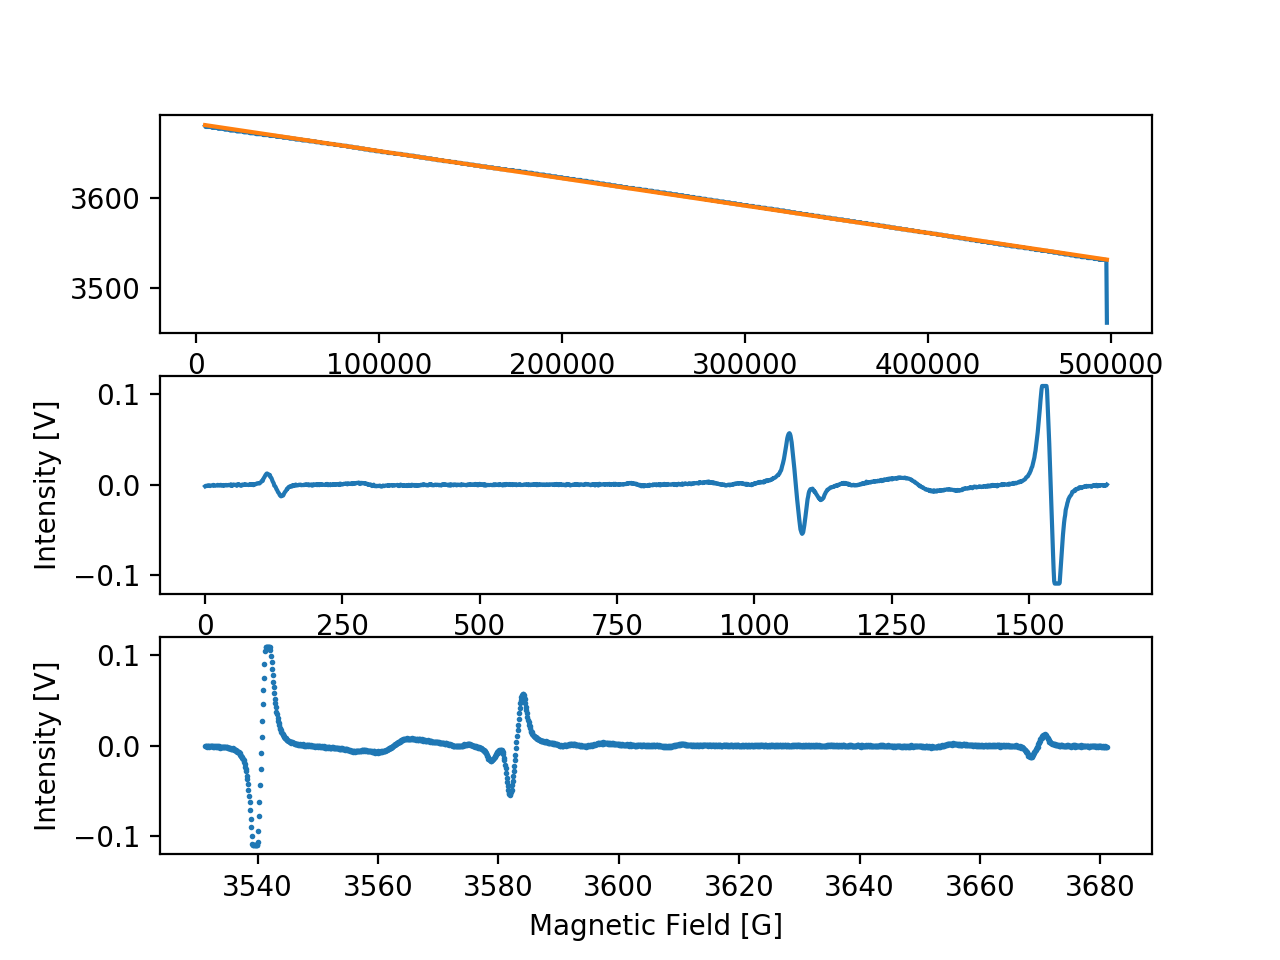

In [43]:
df = pd.read_csv("./data/finalDay_datasweep_50.csv")
B_30, I_30 = plot_data(df)

#### Full Overlayed Spectra

We took our 3 rotation data sets and plotted them on top of each other

<IPython.core.display.Javascript object>


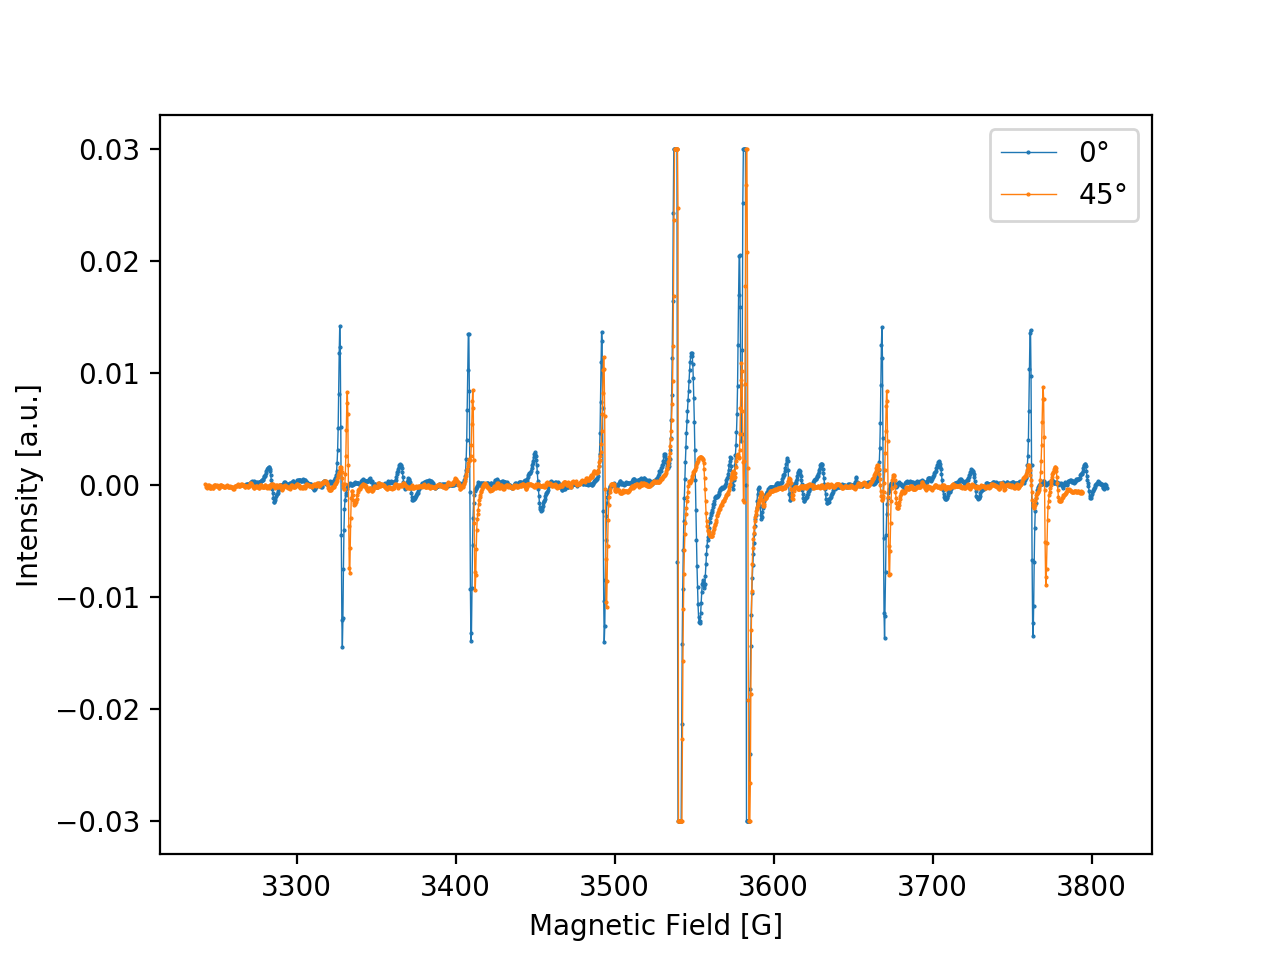

In [44]:
plt.figure()
plt.plot(B_0[50:-220], np.clip(I_0[50:-220], -0.03, 0.03), '.-', label="$0 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_45+2, np.clip(I_45, -0.03, 0.03), '.-', label="$45 \degree$", markersize=1, linewidth=0.5)
plt.legend()
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()

<IPython.core.display.Javascript object>


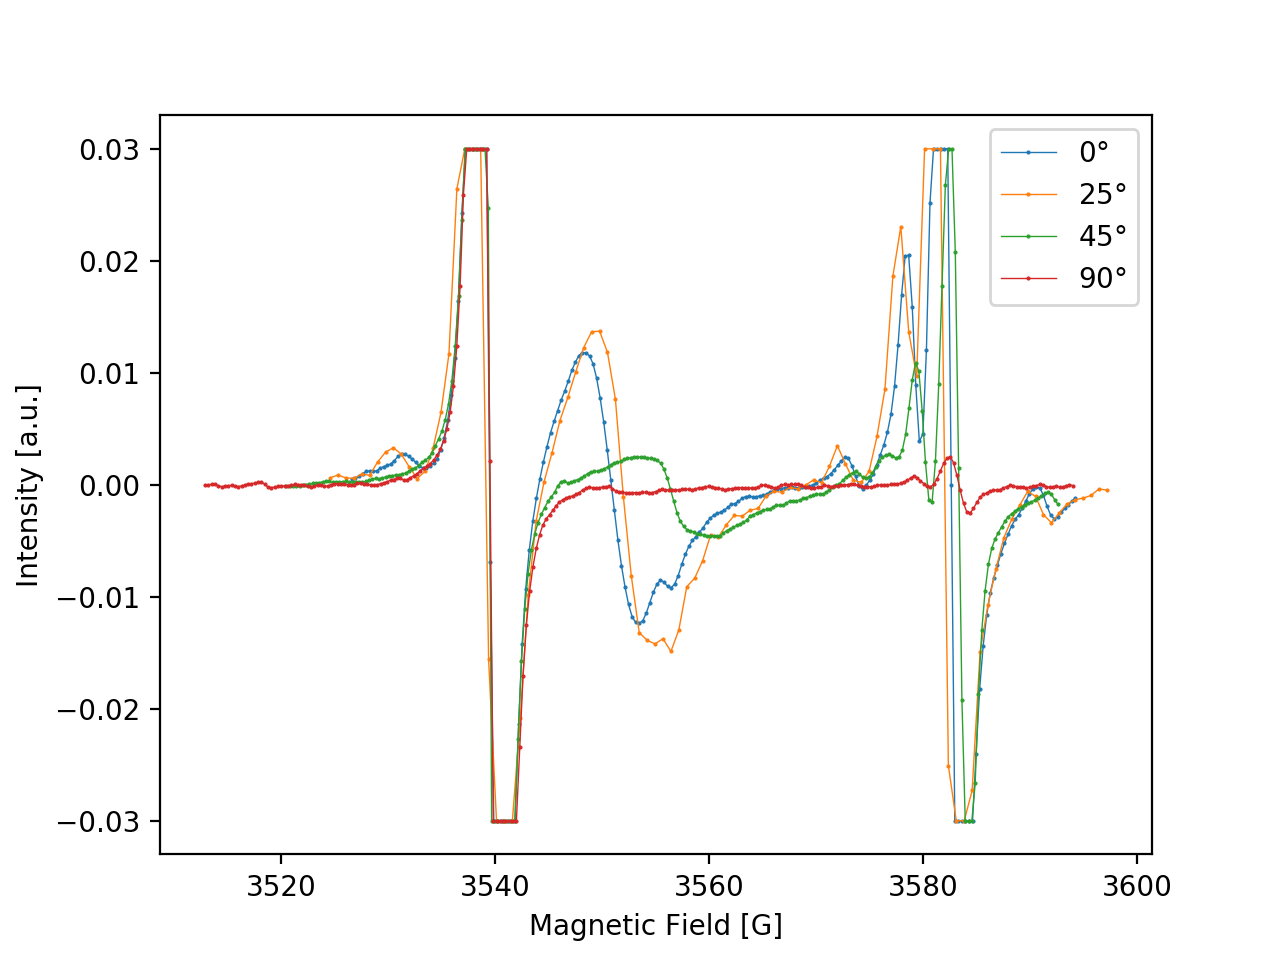

12785


1905

In [45]:
plt.figure()

start_0, end_0 = 700, -1000
start_25, end_25 = 6300, -5000
start_45, end_45 =  650, -900
plt.plot(B_0[start_0:end_0], np.clip(I_0[start_0:end_0], -0.03, 0.03), '.-', label="$0 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_25[start_25:end_25:15]+2, np.clip(-I_25[start_25:end_25:15], -0.03, 0.03), '.-', label="$25 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_45[start_45:end_45]+1.5, np.clip(I_45[start_45:end_45], -0.03, 0.03), '.-', label="$45 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_90[start_45:end_45]+1.5, np.clip(I_90[start_45:end_45], -0.03, 0.03), '.-', label="$90 \degree$", markersize=1, linewidth=0.5)



plt.legend()
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()

print(len(B_25))
len(I_0)

<IPython.core.display.Javascript object>


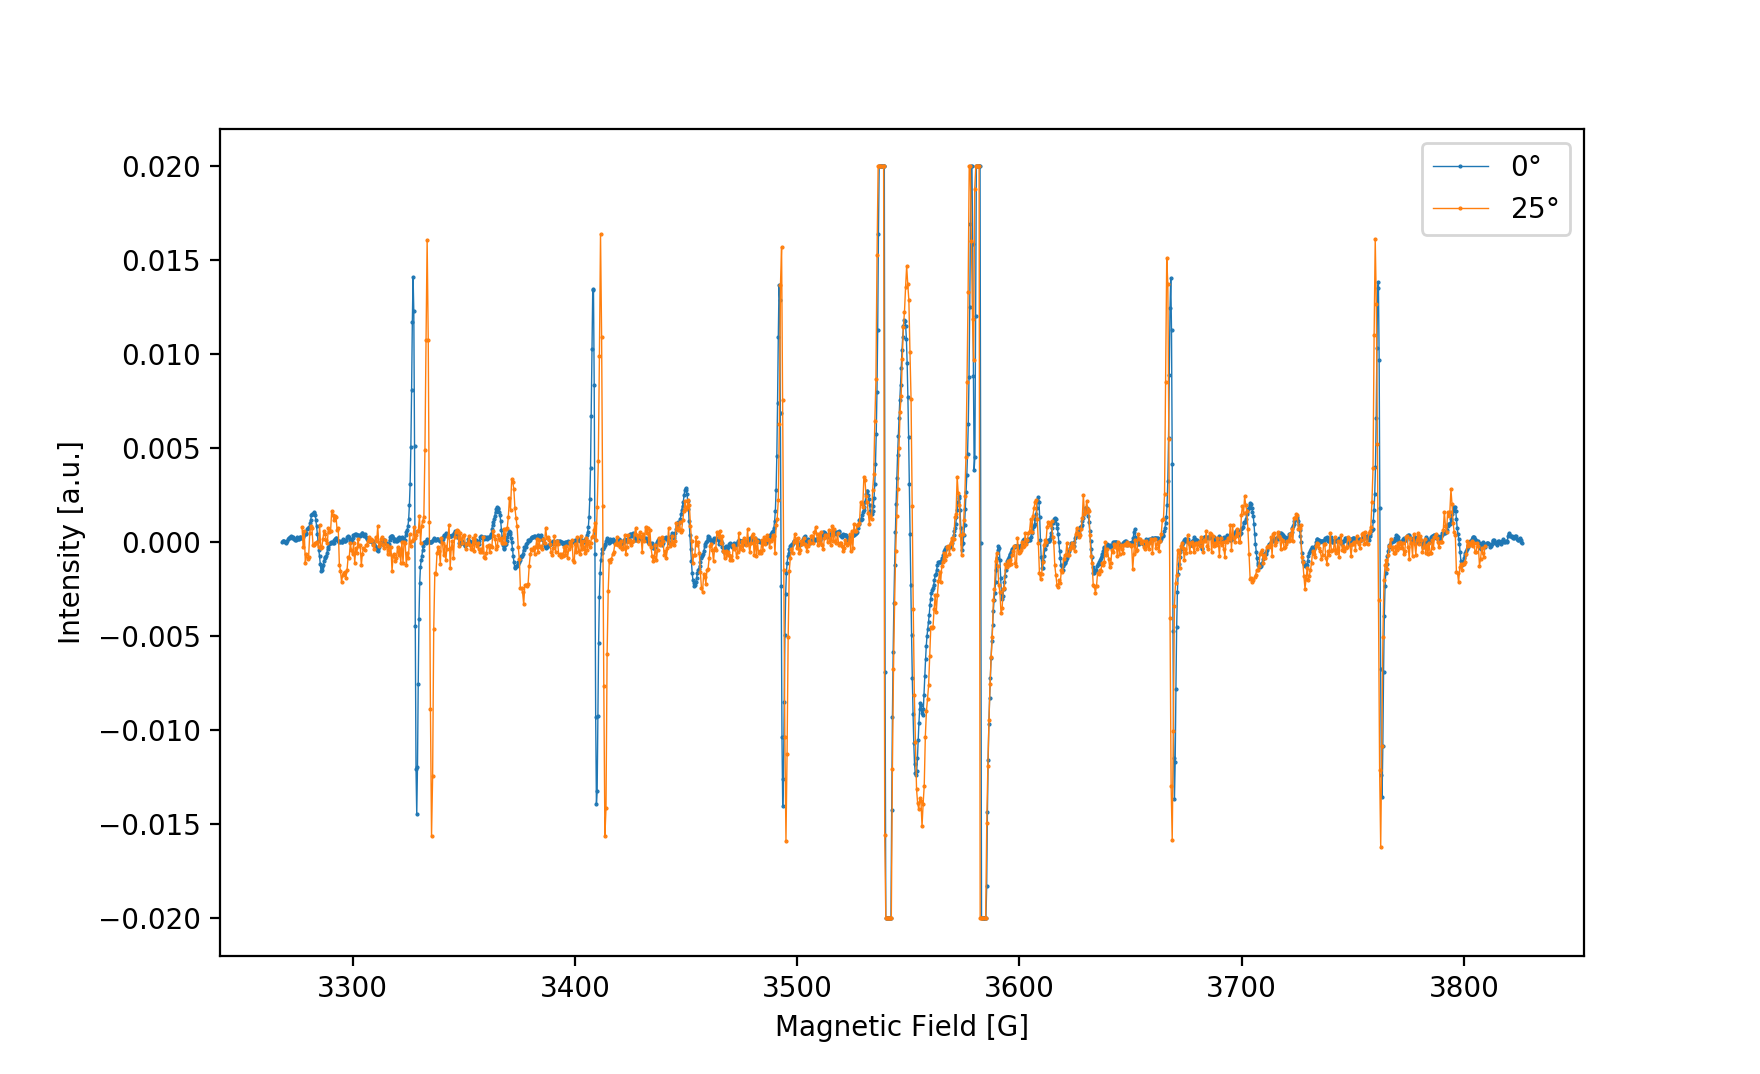

In [46]:
plt.figure()
plt.plot(B_0[:-220], np.clip(I_0[:-220], -0.02, 0.02), '.-', label="$0 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_25[2000::10]+2, np.clip(-I_25[2000::10], -0.02, 0.02), '.-', label="$25 \degree$", markersize=1, linewidth=0.5)
plt.legend()
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()

<IPython.core.display.Javascript object>


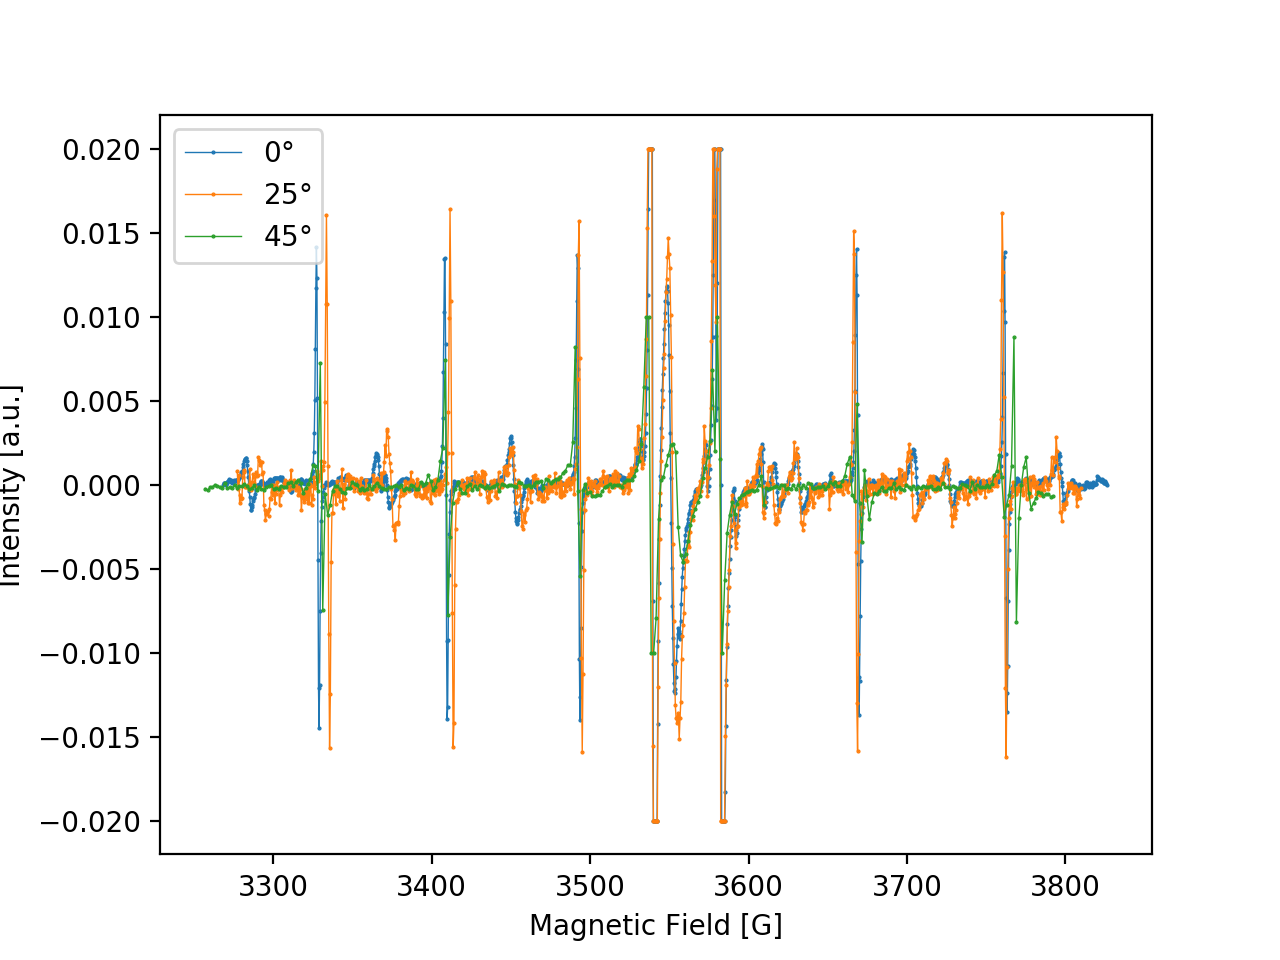

In [47]:
plt.figure()
plt.plot(B_0[:-220], np.clip(I_0[:-220], -0.02, 0.02), '.-', label="$0 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_25[2000::10]+2, np.clip(-I_25[2000::10], -0.02, 0.02), '.-', label="$25 \degree$", markersize=1, linewidth=0.5)
plt.plot(B_45[:-50:5], np.clip(I_45[:-50:5], -0.01, 0.01), '.-', label="$45 \degree$", markersize=1, linewidth=0.5)
plt.legend()
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()

<IPython.core.display.Javascript object>


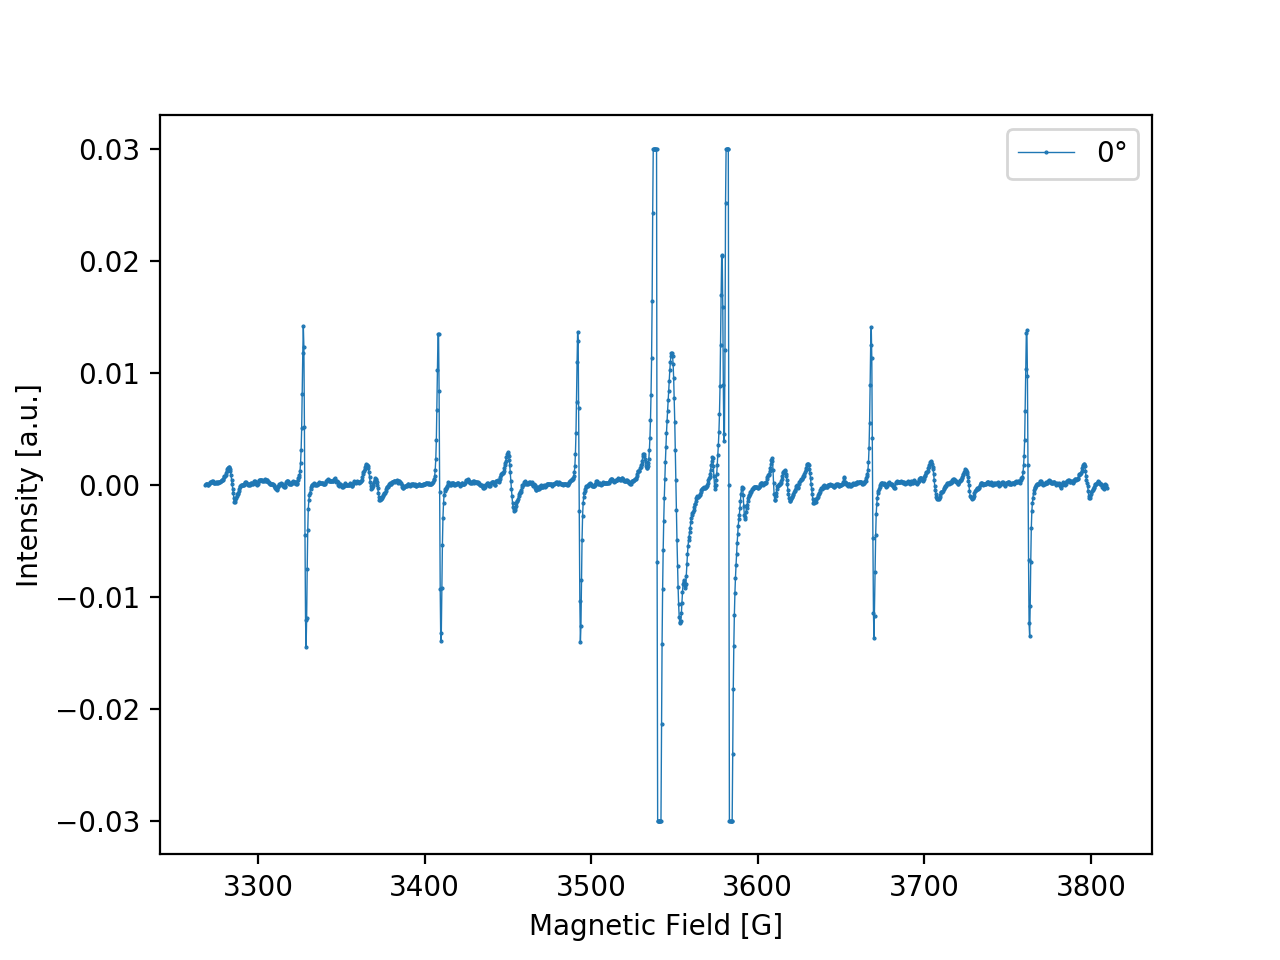

In [48]:
plt.figure()
plt.plot(B_0[50:-220], np.clip(I_0[50:-220], -0.03, 0.03), '.-', label="$0 \degree$", markersize=1, linewidth=0.5)
plt.xlabel("Magnetic Field [G]")
plt.ylabel("Intensity [a.u.]")
plt.legend()